# **Calculate AJD Functions** #

In [ ]:
import scipy
import pandas as pd
import numpy as np
from sklearn import manifold
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import umap
import random
import os
import sys
import csv

def neighbors(data, k=20):
    # for a given dataset, finds the k nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    return indices[:,1:]

def jaccard(A,B):
    # for two sets A and B, finds the Jaccard distance J between A and B
    A = set(A)
    B = set(B)
    union = list(A|B)
    intersection = list(A & B)
    J = ((len(union) - len(intersection))/(len(union)))
    return(J)


def ndr(data,method,dim,n_neighbors=100):
    # Given a dataset, this function performs dimensionality reduction into the
    # dimension specified by dimwith the specified method.
    if method == 'standard_LLE':
        embedding = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors,n_components=dim,\
                method='standard').fit_transform(data)
    elif method == 'hessian_LLE':
        embedding = manifold.LocallyLinearEmbedding(n_neighbors=235,n_components=dim,\
                method='hessian',eigen_solver='dense').fit_transform(data)
    elif method == 'ltsa_LLE':
        embedding = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=dim,\
                method='ltsa',eigen_solver='dense').fit_transform(data)
    elif method == 'modified_LLE':
        embedding = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=dim,\
                method='modified',eigen_solver='dense').fit_transform(data)
    elif method == 'IsoMap':
        embedding = manifold.Isomap(n_neighbors=n_neighbors, n_components=dim)\
            .fit_transform(data)
    elif method == 't-SNE':
        embedding = manifold.TSNE(n_components=dim, init='pca', random_state=0,method='exact')\
                .fit_transform(data)
    elif method == 'MDS':
        embedding = manifold.MDS(n_components=dim, max_iter=100, n_init=1).fit_transform(data)
    elif method == 'Spectral_Embedding':
        embedding = manifold.SpectralEmbedding(n_components=dim,n_neighbors=n_neighbors,eigen_solver= 'arpack' )\
                .fit_transform(data)
    elif method == 'UMAP':
        embedding = umap.UMAP(n_components=dim,n_neighbors=n_neighbors).fit_transform(data)
    elif method == 'PCA':
        embedding = PCA(n_components=dim,svd_solver= 'auto').fit_transform(data)
    embedding = pd.DataFrame(embedding)
    return(embedding)

def ajd(data,embedding,jnn=20):
    # Given a dataset and its lower dimensional representation, this function
    # finds the average jaccard distaqnce between the two.
    print("Finding High-D Neighborhood")
    high_D_neighborhood = neighbors(data,k=jnn)
    print("Finding Low-D Neighborhood...")
    low_D_neighborhood = neighbors(embedding,k=jnn)
    print("Calculating Jaccard Distances...")
    jaccard_distances = 0
    n_samples = data.shape[0]
    i = 0
    while i < n_samples:
        jaccard_distance = jaccard(low_D_neighborhood[i,:],high_D_neighborhood[i,:])
        jaccard_distances = jaccard_distances + jaccard_distance
        i += 1
    result = jaccard_distances/n_samples
    return result

def hypersphere(n_dimensions,n_samples=1000,k_space=20,section=False,offset=0,\
    offset_dimension=0,noise=False,noise_amplitude=.01):
    # This function creates a hyperspherical dataset of arbitrary dimension
    # by sampling from a hypersphere of radius one.
    random.seed()
    data = np.zeros((n_samples,k_space))
    i = 0
    while i < n_samples:
        j = 0
        while j < n_dimensions:
            if section == True:
                a = random.random()
            else:
                a = random.uniform(-1,1)
            data[i,j]=a
            j += 1
        norm = np.linalg.norm(data[i])
        if noise == False:
            data[i] = data[i]/norm
        if noise==True:
            noise_term = (random.uniform(-1,1) * noise_amplitude)
            print(noise_term)
            data[i] = (data[i]/norm) + noise_term
        i += 1
    j = offset_dimension
    if offset != 0:
        i = 0
        while i < n_samples:
            data[i,j] = offset
            i += 1
    data= pd.DataFrame(data)
    # print(data)
    return data

def mst(data):
    # Given a dataset, this function returns a tree structure containing the
    # minimum spanning tree for the dataset
    dist_matrix = scipy.spatial.distance_matrix(data,data)
    tree = scipy.sparse.csgraph.minimum_spanning_tree(dist_matrix)
    return tree

def get_coords(tree):
    # This is a utility function used by the function ged below
    coo = tree.tocoo()
    first = coo.row
    second = coo.col
    coords = []
    i = 0
    while i < len(coo.row):
        coord = tuple((first[i],second[i]))
        coords.append(coord)
        # print(coord)
        i += 1
    return coords

def ged(tree1,tree2):
    # Given two trees, this function finds the graph edit distance between them.
    tree1_coords= get_coords(tree1)
    tree1_inversed = [(item[1],item[0]) for item in tree1_coords]
    tree2_coords= get_coords(tree2)
    tree2_inversed = [(item[1],item[0]) for item in tree2_coords]
    cost = 0
    j = 0
    while j < len(tree1_coords):
        if tree1_coords[j] not in tree2_coords:
            if tree1_inversed[j] not in tree2_coords:
                cost += 1
        j += 1
    j = 0
    while j < len(tree1_coords):
        if tree2_coords[j] not in tree1_coords:
            if tree2_inversed[j] not in tree1_coords:
                cost += 1
        j += 1
    return cost

**Don't run the pip install cell it takes a long time and the packages are already installed**

In [ ]:
!pip install squidpy
!pip install scanpy
!pip install pandas
!pip install numpy
!pip install anndata

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

In [ ]:
%%bash
cd /content/sample_data

pwd

/content/sample_data


In [ ]:
'''
Avoid downloading the original dataset from visium unless needed b/c it takes a long time

'''

img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata() #Already preprocessed and downloaded so just load in the .h5ad file instead
adata
#adata = sc.read_h5ad("/content/mouseliver_unmodified.h5ad")

  0%|          | 0.00/380M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


  0%|          | 0.00/314M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
print(adata)

adata.obs

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AttributeError: 'Index' object has no attribute '_format_flat'

                    in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4928   
AAACAATCTACTAGCA-1          1          3         43               3448   
AAACACCAATAACTGC-1          1         59         19               6022   
AAACAGAGCGACTCCT-1          1         14         94               4311   
AAACCGGGTAGGTACC-1          1         42         28               5787   
...                       ...        ...        ...                ...   
TTGTTGTGTGTCAAGA-1          1         31         77               7016   
TTGTTTCACATCCAGG-1          1         58         42               6995   
TTGTTTCATTAGTCTA-1          1         60         30               5082   
TTGTTTCCATACAACT-1          1         45         27               5661   
TTGTTTGTGTAAATTC-1          1          7         51               5626   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1            

**Dimension Reductions**

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


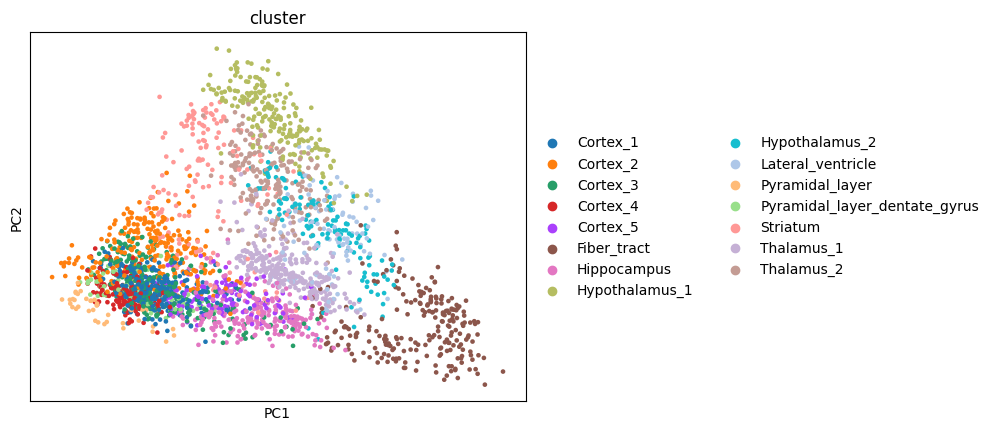

In [ ]:

sc.pl.pca(adata, color = 'cluster')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


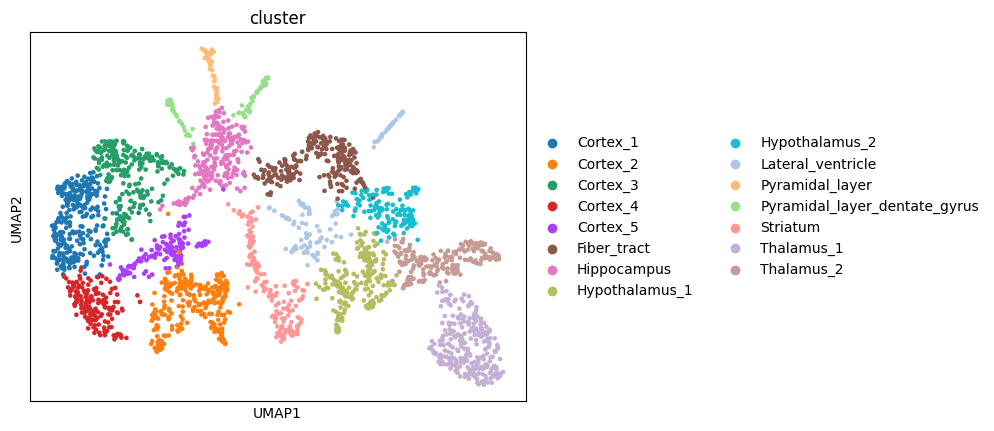

In [ ]:
sc.pl.umap(adata, color = 'cluster')

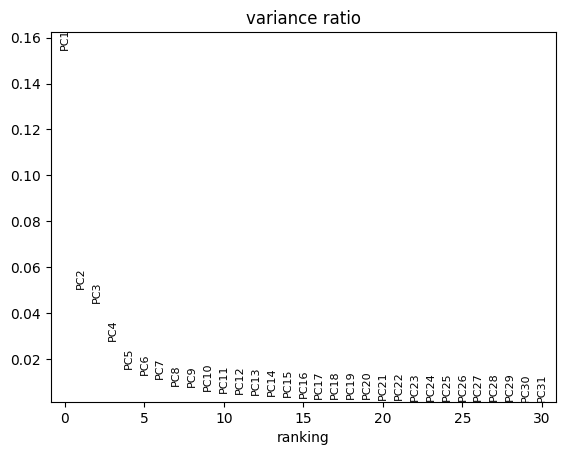

In [ ]:
'''
Elbow plot to determine #PCs
Looks to be around 13-16
'''

sc.pl.pca_variance_ratio(adata)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f6064dae200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1008, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1147, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterp

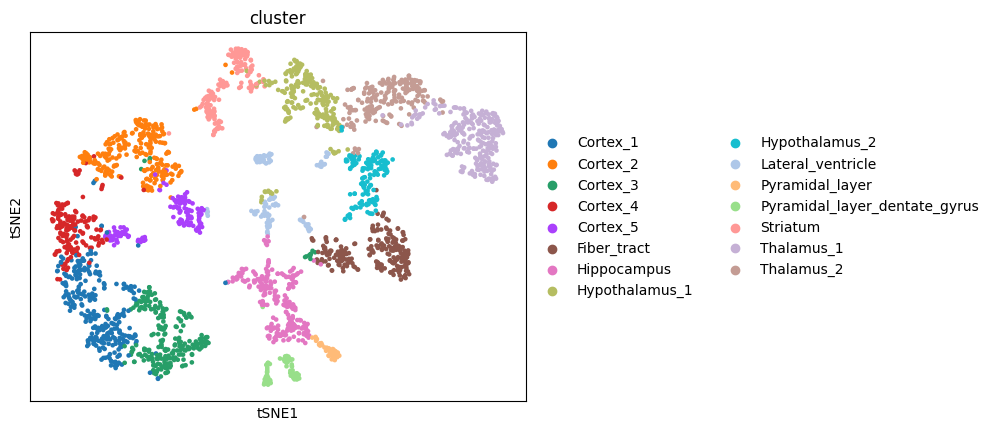

In [ ]:
sc.tl.tsne(adata, n_pcs=16) #16 PCs
sc.pl.tsne(adata, color='cluster')

Extract counts matrix to apply AJD

In [ ]:
pca_df = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
pca_df.to_csv('pca_coordinates.csv')

# Extracting UMAP
umap_df = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)
umap_df.to_csv('umap_coordinates.csv')

# Extracting t-SNE
tsne_df = pd.DataFrame(adata.obsm['X_tsne'], index=adata.obs_names)
tsne_df.to_csv('tsne_coordinates.csv')

ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (/usr/local/lib/python3.10/dist-packages/pandas/_typing.py)

Average Jaccard Distance Example:
PCA with dim =2

In [ ]:

# First, we perform dimensionality reduction:
embedding = ndr(adata.obsm['X_pca'],method='PCA',dim=2)
# Next, we calculate the Average Jaccard Distance:
distortion = ajd(adata.obsm['X_pca'], embedding)
# Finally, we print our result
print("AJD of embedding:  ", distortion)

Dimension Embedding vs. Average Jaccard Distance for Umap

In [ ]:
# Declare some lists to store results:
dims = []
results = []
# For each dimension from 1 to 10:
i = 1
while i < 11:
  # Perform dimensionality reduction:
  embedding = ndr(adata.obsm['X_umap'],method='UMAP',dim=i)
  # Calculate GED:
  avg_jaccard_distance = ajd(adata.obsm['X_umap'],embedding)
  # Add embedding dimensions and AJD result to lists:
  dims.append(i)
  results.append(avg_jaccard_distance)
  i += 1
# Print results:
print(dims)
print(results)

In [ ]:
# Remember to import the package!
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4.5))
plt.plot(dims,results,'bo-')
plt.title('Practice Data \n Dimension of Embedding vs. Avg. Jaccard Distance')
plt.xlabel('Embedding Dimension')
plt.ylabel('Avg. Jaccard Distance')
plt.show()

In [ ]:
sc.write('mouseliver_with_calculated_dimensionreductions.h5ad', adata) #Save adata